# Exercice 2. Detection d'objets en tentant sa chance ...

Dans cette partie, nous allons générer aléatoirement une série de régions. Pour chaque région, nous envisagerons de la faire passer par le classificateur d'objets entraîné (mono- ou multi-catégories) dans l'exercice **1**. Il n'est pas nécessaire de réentraîner le réseau. Effectuez simplement une prediction de la présence ou l'absence d'un objet dans la regions.

Lors de la génération aléatoire des régions, vous pouvez demander la génération de plusieurs types de regions (rectangles debouts, carrés, rectangles couchés). Vous obtiendrez ainsi pour chaque image un ensemble de regions caractérisées par: (x<sub>i</sub>,y<sub>i</sub>,w<sub>i</sub>,h<sub>i</sub>).

**Q1** Ecrire le code de la function qui génére les regions candidates:

In [1]:
import os
import csv
import cv2
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet import preprocess_input

2026-02-09 14:50:33.213534: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-09 14:50:33.213758: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-09 14:50:33.246940: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-09 14:50:34.276228: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

In [2]:

def preselectRegions(image, regions, classifier, input_size=(128,128), threshold=0.5):
    """
    Préselectionne les régions potentiellement contenant un objet.

    Args:
        image: image originale (H,W,3)
        regions: liste de tuples (x,y,w,h)
        classifier: modèle CNN entraîné (binaire ou multiclasse)
        input_size: taille à laquelle redimensionner les régions avant prediction
        threshold: seuil de confiance pour garder une région (pour binaire)

    Returns:
        preselected: liste de [[x, y, w, h, c, logit], ...]
    """
    preselected = []

    for (x, y, w, h) in regions:
        # Extraire la région et redimensionner
        region_crop = image[y:y+h, x:x+w]
        region_resized = cv2.resize(region_crop, input_size)
        region_resized = np.expand_dims(region_resized, axis=0).astype(np.float32)

        # Normalisation si nécessaire (MobileNet)
        if hasattr(classifier.layers[1], 'weights'):  # détection MobileNet
            region_resized = preprocess_input(region_resized)

        # Prédiction
        logits = classifier(region_resized, training=False).numpy()[0]

        if logits.size == 1:
            # Binaire
            prob = logits[0]
            if prob >= threshold:
                preselected.append([x, y, w, h, 1, prob])
        else:
            # Multiclasse
            c = int(np.argmax(logits))
            logit_c = logits[c]
            preselected.append([x, y, w, h, c, logit_c])

    return preselected


In [3]:
def generate_random_regions(img_shape, n_regions=10, min_size_ratio=0.1, max_size_ratio=0.5):
    H, W = img_shape[:2]
    regions = []

    for _ in range(n_regions):
        # choisir le type de région : carré, rectangle debout, rectangle couché
        region_type = random.choice(['square', 'portrait', 'landscape'])
        
        # largeur et hauteur aléatoires
        size_ratio = random.uniform(min_size_ratio, max_size_ratio)
        if region_type == 'square':
            w = h = int(size_ratio * min(W, H))
        elif region_type == 'portrait':  # rectangle debout
            w = int(size_ratio * W * 0.6)
            h = int(size_ratio * H * 1.2)
        else:  # 'landscape' rectangle couché
            w = int(size_ratio * W * 1.2)
            h = int(size_ratio * H * 0.6)
        
        # limiter la taille pour rester dans l'image
        w = min(w, W)
        h = min(h, H)
        
        # position aléatoire
        x = random.randint(0, W - w)
        y = random.randint(0, H - h)
        
        regions.append((x, y, w, h))
    
    return regions


Vous passerez chacune de ces regions par le réseau (de l'exercice **1**) et vous conserverez uniquement celles pour lesquelles un objet a été reconnu.

Conserver la classe et la valeur du logit correspondant qui nous servira à évaluer la confiance en la detection. Ainsi, pour chaque image vous avez une nouvelle description des regions (x<sub>i</sub>,y<sub>i</sub>,w<sub>i</sub>,h<sub>i</sub>,c<sub>i</sub>,logit<sub>i</sub>) où c<sub>i</sub> correspond à la classe et logit<sub>i</sub> au logit ayant déterminé la classe (il jouera le rôle de la confiance qu'on fait en la detection).

**Q2** Ecrire le code de la fonction qui preselectionne les régions contenant un objet potentiel:

In [4]:
def preselectRegions(image, regions, classifier, input_size=(128,128), threshold=0.5):
    preselected = []

    for (x, y, w, h) in regions:
        # Extraire la région et redimensionner
        region_crop = image[y:y+h, x:x+w]

        if region_crop.shape == 0:
            continue

        region_resized = cv2.resize(region_crop, input_size)
        region_resized = np.expand_dims(region_resized, axis=0).astype(np.float32)

        # Normalisation si nécessaire (MobileNet)
        if hasattr(classifier.layers[1], 'weights'):  # détection MobileNet
            region_resized = preprocess_input(region_resized)

        # Prédiction
        logits = classifier(region_resized, training=False).numpy()[0]

        if logits.size == 1:
            # Binaire
            prob = logits[0]
            if prob >= threshold:
                preselected.append([x, y, w, h, 1, prob])
        else:
            # Multiclasse
            c = int(np.argmax(logits))
            logit_c = logits[c]
            preselected.append([x, y, w, h, c, logit_c])

    return preselected


Pour les régions classées comme contenant un objet, appliquez l'algorithme de suppression des non-maxima classe par classe.

Triez les régions par ordre décroissant de score de confiance/prédiction.

Calculez l'IoU entre la première région de la liste et toutes les autres. Si l'IoU est supérieur au seuil, supprimez la région correspondante de la liste.

Répétez l'opération jusqu'à ce que toutes les régions aient été traitées ou supprimées.

**Q3** Proposez une implementation pour le calcul de l'IoU et pour l'algorithm de NonMaxSuppression

In [5]:
def IoU(regionA, regionB):
    xA = max(regionA[0], regionB[0])
    yA = max(regionA[1], regionB[1])
    xB = min(regionA[0] + regionA[2], regionB[0] + regionB[2])
    yB = min(regionA[1] + regionA[3], regionB[1] + regionB[3])

    # intersection width/height
    inter_w = max(0, xB - xA)
    inter_h = max(0, yB - yA)
    inter_area = inter_w * inter_h

    # union
    areaA = regionA[2] * regionA[3]
    areaB = regionB[2] * regionB[3]
    union_area = areaA + areaB - inter_area

    if union_area == 0:
        return 0
    else:
        return inter_area / union_area

        
def nonmaxSuppression(image, classes, regionsWithClassAndLogit, iou_threshold=0.5):
    selected_regions = []

    for cls in classes:
        # extraire les régions de cette classe
        cls_regions = [r for r in regionsWithClassAndLogit if r[4] == cls]

        # trier par logit décroissant
        cls_regions = sorted(cls_regions, key=lambda r: r[5], reverse=True)

        keep = []
        while cls_regions:
            # prendre la première région
            current = cls_regions.pop(0)
            keep.append(current)

            # supprimer toutes les régions qui se chevauchent trop
            cls_regions = [r for r in cls_regions if IoU(current, r) <= iou_threshold]

        selected_regions.extend(keep)

    return selected_regions


**Q4** Calculez ensuite, pour chaque région restante, l'IoU avec les boîtes englobantes consituant la vérité de terrain et gardez uniquement les fenetre avec un IoU supperieur à un seuil fixé. Parcourez les regions en fonction des leur niveau de confiance. Au fur et à mesure que les groundtruth_regions se voient attribuer une candidate_region, il faut enlever cette groundtruth_region de la liste afin d'éviter que plusieurs regions candidates soient ratachées à la même région de la groundtruth.

In [6]:
def compareToGroundTruth(image, groundtruth_regions, candidate_regions, iou_threshold=0.5):
    # Trier les candidates par logit décroissant
    candidates_sorted = sorted(candidate_regions, key=lambda r: r[5], reverse=True)

    TPRegions = []
    FNDetected = []
    # Faire une copie des ground-truth pour enlever au fur et à mesure
    remaining_gt = groundtruth_regions.copy()

    for cand in candidates_sorted:
        matched = False
        best_iou = 0
        best_gt = None
        for gt in remaining_gt:
            iou = IoU(cand, gt)
            if iou > best_iou:
                best_iou = iou
                best_gt = gt

        if best_iou >= iou_threshold:
            TPRegions.append(cand)
            remaining_gt.remove(best_gt)
            matched = True
        else:
            FNDetected.append(cand)

    # Les gt restant sont les FN non détectés
    FNNonDetected = remaining_gt

    return TPRegions, FNDetected, FNNonDetected


## Détection d'une classe d'objets

Appliquez la procédure à l'ensemble d'images contenant l'étiquette 4 (Éléphant). 
Nous ne découperons plus par rapport à l'éléphant, mais considérons l'image dans son ensemble. 
Dans cette situation, nous considérons que tout autre objet apparaîssant sur les images que l'éléphant fait partie de l'arrière plan. 
Lors du chargement des données, uniquement les regions concernant l'éléphant feront partie de la vérité de terrain.

Utilisez un classifier binaire capable de reconnaître un éléphant.

Vous devez coder une nouvelle version de la fonction `load_elephant_objects` afin de prendre en compte ces considérations.

**Q5** Coder `load_elephant_objects`

In [7]:
def load_elephant_objects(imgs_path, max_samples=None):
    x = []
    y = []
    count_samples = 0

    if max_samples is None:
        max_samples = np.iinfo(np.int32).max  # valeur maximale par défaut

    imgs_files = os.listdir(imgs_path + "images/")
    for i, img_file in enumerate(imgs_files):
        if count_samples >= max_samples:
            break

        label_file = img_file[:-4] + ".txt"
        img_init = cv2.imread(imgs_path + "images/" + img_file)
        if img_init is None:
            continue

        labels = csv.reader(open(imgs_path + "labels/" + label_file, "r"), delimiter=' ')
        rows = list(labels)

        elephant_boxes = []
        for row in rows:
            if row[0] != '4':  # garder uniquement les éléphants
                continue

            bbox = np.array(row[1:], dtype=np.float32)
            w = int(bbox[2] * img_init.shape[1])
            h = int(bbox[3] * img_init.shape[0])
            x0 = max(0, int(bbox[0] * img_init.shape[1] - w / 2))
            y0 = max(0, int(bbox[1] * img_init.shape[0] - h / 2))
            x1 = min(img_init.shape[1], int(x0 + w))
            y1 = min(img_init.shape[0], int(y0 + h))

            elephant_boxes.append([x0, y0, x1 - x0, y1 - y0])

        if elephant_boxes:
            x.append(img_init)
            y.append(elephant_boxes)
            count_samples += 1

    return x, y


In [8]:
data_path = "../data/toy-dataset"
train_path = os.path.join(data_path, "train/")
test_path = os.path.join(data_path, "test/")

In [9]:
# Charger les images de test contenant des éléphants
x_test, y_test = load_elephant_objects(test_path)  # test_path = "../data/toy-dataset/test/"

print("Nombre d'images test contenant des éléphants :", len(x_test))
for i, boxes in enumerate(y_test[:5]):
    print(f"Image {i} : {len(boxes)} éléphant(s) - boxes :", boxes)


Nombre d'images test contenant des éléphants : 30
Image 0 : 1 éléphant(s) - boxes : [[307, 34, 52, 62]]
Image 1 : 1 éléphant(s) - boxes : [[316, 43, 40, 90]]
Image 2 : 1 éléphant(s) - boxes : [[137, 31, 43, 73]]
Image 3 : 1 éléphant(s) - boxes : [[285, 150, 35, 88]]
Image 4 : 1 éléphant(s) - boxes : [[188, 193, 45, 89]]


**Q6** Pour chaque image du test set affichez le nombre de TP, FP, TN.
Choissisez un sous-ensemble de 3 images sur lesquelles vous superposer en vert la GT, en blue les TP, en orange les FP et en rouge les FN.

In [10]:
def evaluate_image(image, groundtruth_boxes, candidate_regions, iou_threshold=0.5):
    TP, FP, FN = compareToGroundTruth(image, groundtruth_boxes, candidate_regions, iou_threshold)
    
    # Pour TN : dans notre cas, toutes les régions candidates non détectées et qui ne contiennent pas d'éléphant
    TNCount = 0  # si on ne génère pas explicitement les candidates négatives, TN = 0
    return TP, FP, FN, TNCount


In [11]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_multiple_images_with_gt_tp_fp_fn(x_test, y_test, model_binary, generate_random_regions,
    preselectRegions, nonmaxSuppression, compareToGroundTruth, iou_threshold=0.5, n_images=3
):
    """
    Affiche plusieurs images avec GT / TP / FP / FN sur une seule figure
    avec une légende des couleurs
    """

    fig, axes = plt.subplots(1, n_images, figsize=(6 * n_images, 6))

    if n_images == 1:
        axes = [axes]

    for i in range(n_images):
        img = x_test[i]
        gt_boxes = y_test[i]

        # Génération et filtrage des régions
        regions = generate_random_regions(img.shape, n_regions=20)
        candidate_regions = preselectRegions(
            img, regions, model_binary,
            input_size=(128, 128), threshold=0.5
        )
        candidate_regions_nms = nonmaxSuppression(
            img, [1], candidate_regions, iou_threshold=0.5
        )

        TP, FP, FN = compareToGroundTruth(
            img, gt_boxes, candidate_regions_nms,
            iou_threshold=iou_threshold
        )

        img_disp = img.copy()

        # Ground Truth - vert
        for r in gt_boxes:
            x, y, w, h = r[:4]
            cv2.rectangle(img_disp, (x, y), (x+w, y+h), (0, 255, 0), 2)

        # True Positives - bleu
        for r in TP:
            x, y, w, h = r[:4]
            cv2.rectangle(img_disp, (x, y), (x+w, y+h), (0, 0, 255), 2)

        # False Positives - orange
        for r in FP:
            x, y, w, h = r[:4]
            cv2.rectangle(img_disp, (x, y), (x+w, y+h), (255, 165, 0), 2)

        # False Negatives - rouge
        for r in FN:
            x, y, w, h = r[:4]
            cv2.rectangle(img_disp, (x, y), (x+w, y+h), (255, 0, 0), 2)

        axes[i].imshow(img_disp)
        axes[i].axis('off')
        axes[i].set_title(f"Image {i}")

    # --- LÉGENDE ---
    legend_elements = [
        mpatches.Patch(color='green', label='Ground Truth'),
        mpatches.Patch(color='blue', label='True Positive'),
        mpatches.Patch(color='orange', label='False Positive'),
        mpatches.Patch(color='red', label='False Negative')
    ]

    fig.legend(
        handles=legend_elements,
        loc='lower center',
        ncol=4,
        frameon=True
    )

    plt.tight_layout(rect=[0, 0.08, 1, 1])
    plt.show()


In [12]:
model_binary = load_model("model_elephant_binary.keras")

2026-02-09 14:50:35.448025: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [13]:
iou_threshold = 0.5
results = []

for img, gt_boxes in zip(x_test, y_test):
    # 1. Générer des régions candidates
    regions = generate_random_regions(img.shape, n_regions=20)
    
    # 2. Préselection par CNN binaire
    candidate_regions = preselectRegions(img, regions, model_binary, input_size=(128,128), threshold=0.5)
    
    # 3. NMS
    classes_present = [1]  # binaire : 1 = éléphant
    candidate_regions_nms = nonmaxSuppression(img, classes_present, candidate_regions, iou_threshold=0.5)
    
    # 4. Évaluation vs GT
    TP, FP, FN = compareToGroundTruth(img, gt_boxes, candidate_regions_nms, iou_threshold=iou_threshold)
    TN = 0  # on ne génère pas explicitement les TN ici
    results.append([len(TP), len(FP), TN, len(FN)])

# Affichage des résultats
for i, (TPc, FPc, TNc, FNc) in enumerate(results):
    print(f"Image {i}: TP={TPc}, FP={FPc}, TN={TNc}, FN={FNc}")


Image 0: TP=0, FP=5, TN=0, FN=1
Image 1: TP=0, FP=10, TN=0, FN=1
Image 2: TP=0, FP=6, TN=0, FN=1
Image 3: TP=0, FP=10, TN=0, FN=1
Image 4: TP=0, FP=10, TN=0, FN=1
Image 5: TP=0, FP=7, TN=0, FN=1
Image 6: TP=0, FP=9, TN=0, FN=1
Image 7: TP=0, FP=7, TN=0, FN=1
Image 8: TP=0, FP=10, TN=0, FN=1
Image 9: TP=0, FP=9, TN=0, FN=1
Image 10: TP=0, FP=3, TN=0, FN=1
Image 11: TP=0, FP=10, TN=0, FN=1
Image 12: TP=0, FP=9, TN=0, FN=1
Image 13: TP=0, FP=10, TN=0, FN=1
Image 14: TP=0, FP=9, TN=0, FN=1
Image 15: TP=0, FP=4, TN=0, FN=1
Image 16: TP=0, FP=9, TN=0, FN=1
Image 17: TP=0, FP=10, TN=0, FN=1
Image 18: TP=0, FP=8, TN=0, FN=1
Image 19: TP=0, FP=7, TN=0, FN=1
Image 20: TP=0, FP=9, TN=0, FN=1
Image 21: TP=0, FP=7, TN=0, FN=1
Image 22: TP=0, FP=6, TN=0, FN=1
Image 23: TP=0, FP=9, TN=0, FN=1
Image 24: TP=0, FP=15, TN=0, FN=1
Image 25: TP=0, FP=10, TN=0, FN=1
Image 26: TP=0, FP=10, TN=0, FN=1
Image 27: TP=0, FP=12, TN=0, FN=1
Image 28: TP=0, FP=8, TN=0, FN=1
Image 29: TP=0, FP=11, TN=0, FN=1


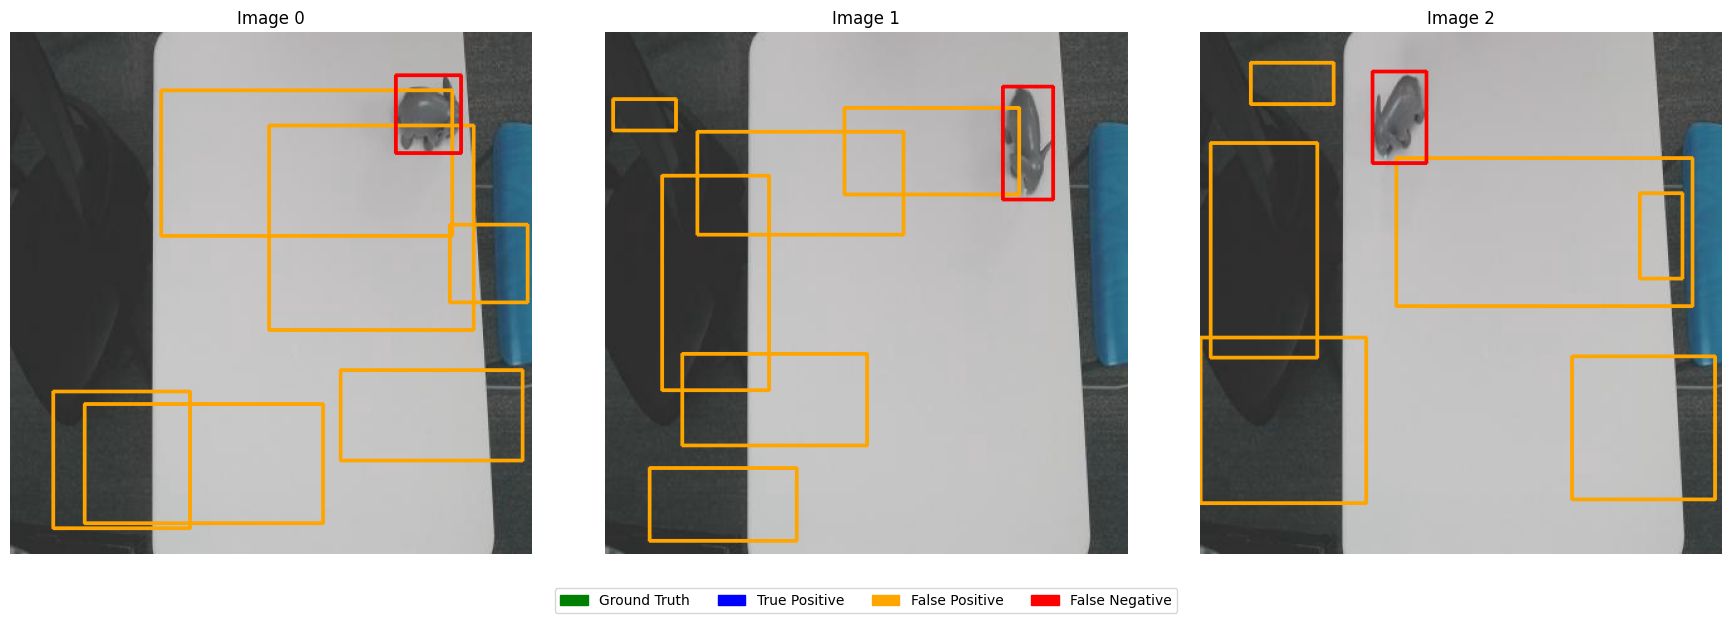

In [14]:
plot_multiple_images_with_gt_tp_fp_fn(
    x_test=x_test,
    y_test=y_test,
    model_binary=model_binary,
    generate_random_regions=generate_random_regions,
    preselectRegions=preselectRegions,
    nonmaxSuppression=nonmaxSuppression,
    compareToGroundTruth=compareToGroundTruth,
    iou_threshold=0.5,
    n_images=3
)


**Q7** Calculez la précision moyenne (AP) pour les images relevant de cette étiquette sur le test set pour un IoU de 0.5.

Afin de calculer la précision moyenne, il est nécessaire de traiter l'ensemble des detections dans leur globalité par rapport à leur niveau de confiance.

Regroupez dans une liste l'ensemble de regions candidates issues de **Q4** tout en conservant une information relative à leur appartenance aux ensembles TPregions ou FPregions. Triez cette liste en fonction de niveau de confiance et parcourez la de manière décroissante.

Initialement le rappel est à zero car TP=0, FP=0 et FN=#total regions issues de la **Q4**
Au fur et à mesure qu'on traite des regions de la liste on met à jour les valeurs cumulées TP et FP pour calculer la précion et le rappel à chaque nouvelle detection.

Tracez un graphique des points (précision, rappel) intermediaires.

Vous pouvez utiliser la fonction `sklearn.metrics.auc` pour calculer la valeur d'AUC en fournissant les listes avec les valeurs intermediaires de (précision et rappel).

In [15]:
from sklearn.metrics import auc
import matplotlib.pyplot as plt

def compute_average_precision(x_test, y_test, model_binary,
                              generate_random_regions,
                              preselectRegions,
                              nonmaxSuppression,
                              compareToGroundTruth,
                              iou_threshold=0.5,
                              n_regions=20):
    """
    Calcule l'Average Precision (AP) pour le test set éléphant.

    Args:
        x_test: liste d'images
        y_test: liste de GT boxes correspondantes
        model_binary: modèle CNN binaire pour l'éléphant
        generate_random_regions: fonction pour générer des régions aléatoires
        preselectRegions: fonction pour préselectionner les régions candidates
        nonmaxSuppression: fonction NMS
        compareToGroundTruth: fonction pour comparer aux GT
        iou_threshold: seuil IoU pour considérer une détection correcte
        n_regions: nombre de régions aléatoires générées par image

    Returns:
        precisions: liste des précisions cumulées
        recalls: liste des rappels cumulés
        AP: Average Precision
    """

    all_detections = []  # [(score, is_tp)]
    total_gt = 0

    # --- Parcourir toutes les images ---
    for img, gt_boxes in zip(x_test, y_test):
        total_gt += len(gt_boxes)

        # 1. Générer des régions candidates
        regions = generate_random_regions(img.shape, n_regions=n_regions)

        # 2. Préselection par CNN
        candidates = preselectRegions(
            img, regions, model_binary,
            input_size=(128, 128), threshold=0.5
        )

        # 3. Non-Max Suppression
        candidates_nms = nonmaxSuppression(img, [1], candidates, iou_threshold=iou_threshold)

        # 4. Comparaison aux ground-truth
        TP, FP, FN = compareToGroundTruth(img, gt_boxes, candidates_nms, iou_threshold=iou_threshold)

        # --- Ajouter toutes les detections à la liste globale ---
        for r in TP:
            all_detections.append((r[5], 1))  # logit, TP
        for r in FP:
            all_detections.append((r[5], 0))  # logit, FP

    # --- Trier par confiance décroissante ---
    all_detections = sorted(all_detections, key=lambda x: x[0], reverse=True)

    # --- Calcul précision / rappel cumulés ---
    precisions = []
    recalls = []
    tp_cum = 0
    fp_cum = 0

    for score, is_tp in all_detections:
        if is_tp:
            tp_cum += 1
        else:
            fp_cum += 1

        precision = tp_cum / (tp_cum + fp_cum)
        recall = tp_cum / total_gt

        precisions.append(precision)
        recalls.append(recall)

    # --- Calcul AP ---
    AP = auc(recalls, precisions)

    # --- Tracé Precision-Recall ---
    plt.figure(figsize=(6, 6))
    plt.plot(recalls, precisions, marker='o')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision–Recall curve (Elephant, IoU={iou_threshold})")
    plt.grid(True)
    plt.show()

    print(f"Average Precision (AP) @ IoU={iou_threshold}: {AP:.4f}")

    return precisions, recalls, AP


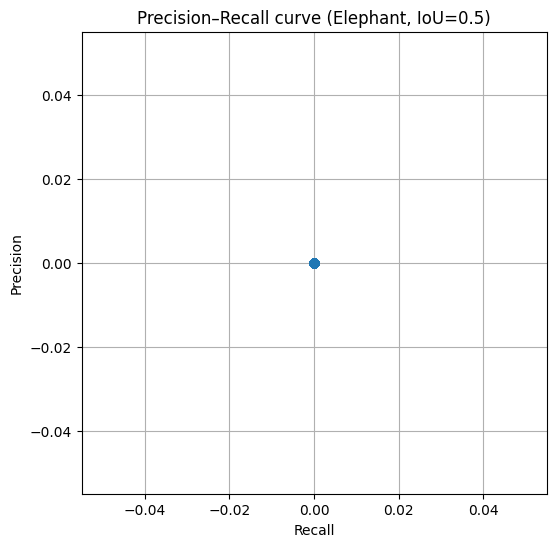

Average Precision (AP) @ IoU=0.5: 0.0000


In [16]:
precisions, recalls, AP = compute_average_precision(
    x_test, y_test, model_binary,
    generate_random_regions,
    preselectRegions,
    nonmaxSuppression,
    compareToGroundTruth,
    iou_threshold=0.5,
    n_regions=20
)


## Détection de plusieurs classes

Appliquez la procédure à l'ensemble d'images du dataset. 
Lors du chargement des données, l'ensemble des regions concernant des objets feront partie de la vérité de terrain. Cette fois-ci l'on gardera également des informations sur la classe spécifique associée à une boîte englobante.

**Q7** Vous devez coder une nouvelle version de la fonction `load_objects` afin de prendre en compte ces considérations.

In [17]:
def load_objects(imgs_path, max_samples=None):
    x = []
    y = []
    count_samples = 0

    if max_samples is None:
        max_samples = np.iinfo(np.int32).max

    imgs_files = os.listdir(os.path.join(imgs_path, "images"))
    for i, img_file in enumerate(imgs_files):
        if count_samples >= max_samples:
            break

        label_file = img_file[:-4] + ".txt"
        img_init = cv2.imread(os.path.join(imgs_path, "images", img_file))
        if img_init is None:
            continue

        label_path = os.path.join(imgs_path, "labels", label_file)
        if not os.path.exists(label_path):
            continue

        with open(label_path, "r") as f:
            labels = list(csv.reader(f, delimiter=' '))

        boxes = []
        for row in labels:
            # row = [class_id, x_center, y_center, width, height] (normalisé)
            c = int(row[0])
            bbox = np.array(row[1:], dtype=np.float32)

            w = int(bbox[2] * img_init.shape[1])
            h = int(bbox[3] * img_init.shape[0])
            x0 = max(0, int(bbox[0] * img_init.shape[1] - w / 2))
            y0 = max(0, int(bbox[1] * img_init.shape[0] - h / 2))
            x1 = min(img_init.shape[1], x0 + w)
            y1 = min(img_init.shape[0], y0 + h)

            boxes.append([x0, y0, x1 - x0, y1 - y0, c])

        if boxes:
            x.append(img_init)
            y.append(boxes)
            count_samples += 1

    return x, y


**Q8** Calculez la précision moyenne (AP) pour l'ensemble de données pour un IoU de 0.5.
Par rapport au cas mono-classe, il est d'usage de calculer l'AUC classe par classe (et donc considerer les régions classe par classe) avant de calculer une moyenne qui tient compte de nombre d'instance de chaque classe.

In [18]:
from sklearn.metrics import auc
import matplotlib.pyplot as plt

def compute_average_precision_multiclass(x_test, y_test, model_multi,
                                         generate_random_regions,
                                         preselectRegions,
                                         nonmaxSuppression,
                                         compareToGroundTruth,
                                         iou_threshold=0.5,
                                         n_regions=20):

    classes = set()
    for boxes in y_test:
        for b in boxes:
            if len(b) == 5:
                classes.add(b[4])
    classes = list(classes)

    AP_per_class = {}
    total_instances = {c: 0 for c in classes}

    for boxes in y_test:
        for b in boxes:
            total_instances[b[4]] += 1

    for cls in classes:
        all_detections = []
        total_gt = total_instances[cls]
        for img, gt_boxes in zip(x_test, y_test):
            gt_cls = [b[:4] for b in gt_boxes if b[4] == cls]

            if len(gt_cls) == 0:
                continue

            regions = generate_random_regions(img.shape, n_regions=n_regions)
            candidates = preselectRegions(img, regions, model_multi, input_size=(128,128), threshold=0.5)
            candidates_nms = nonmaxSuppression(img, [cls], candidates, iou_threshold=iou_threshold)

            TP, FP, FN = compareToGroundTruth(img, gt_cls, candidates_nms, iou_threshold=iou_threshold)

            for r in TP:
                all_detections.append((r[5], 1))
            for r in FP:
                all_detections.append((r[5], 0))

        all_detections = sorted(all_detections, key=lambda x: x[0], reverse=True)

        precisions = []
        recalls = []
        tp_cum = 0
        fp_cum = 0

        for score, is_tp in all_detections:
            if is_tp:
                tp_cum += 1
            else:
                fp_cum += 1

            precision = tp_cum / (tp_cum + fp_cum) if (tp_cum + fp_cum) > 0 else 0
            recall = tp_cum / total_gt if total_gt > 0 else 0

            precisions.append(precision)
            recalls.append(recall)

        AP_cls = auc(recalls, precisions) if precisions else 0
        AP_per_class[cls] = AP_cls
        plt.figure(figsize=(5,5))
        plt.plot(recalls, precisions, marker='o')
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision–Recall (Class {cls})")
        plt.grid(True)
        plt.show()

        print(f"AP Class {cls}: {AP_cls:.4f}")

    # --- Moyenne pondérée ---
    mean_AP = sum(AP_per_class[c] * total_instances[c] for c in classes) / sum(total_instances.values())
    print(f"Mean AP (multi-class, IoU={iou_threshold}): {mean_AP:.4f}")

    return AP_per_class, mean_AP


In [19]:
model_multi = tf.keras.models.load_model('model_multi.keras')

/home/nicolas/Etude/amvo/.venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 6 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [20]:
x_test, y_test = load_objects(test_path)

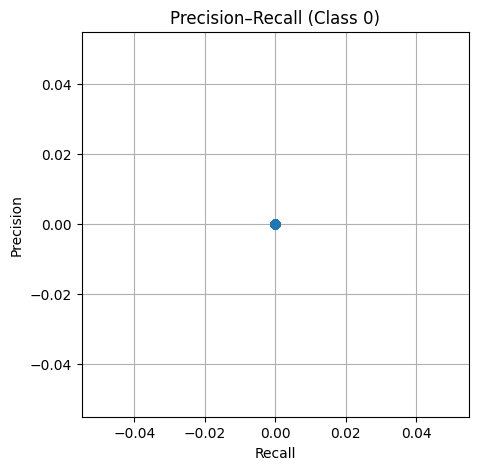

AP Class 0: 0.0000


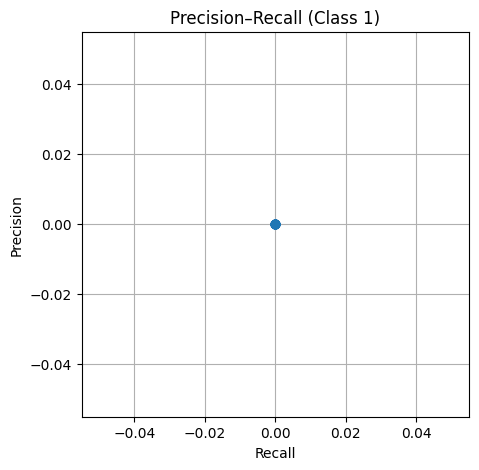

AP Class 1: 0.0000


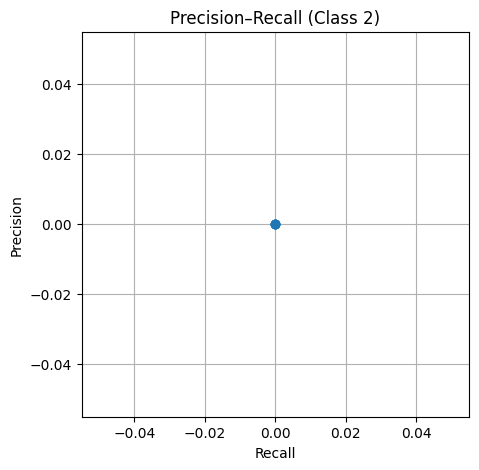

AP Class 2: 0.0000


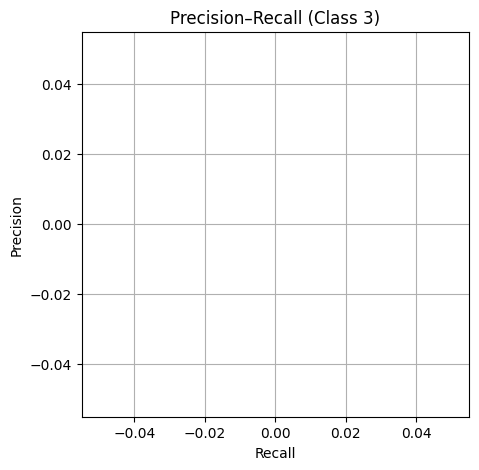

AP Class 3: 0.0000


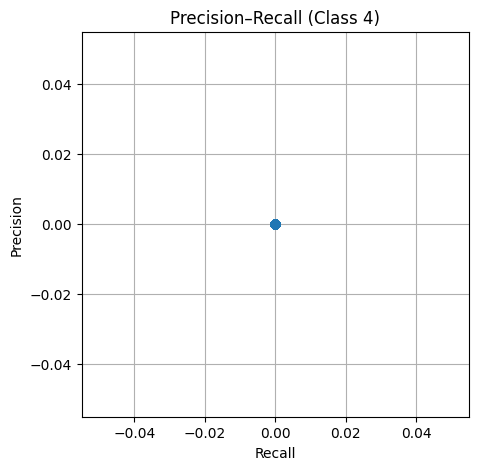

AP Class 4: 0.0000


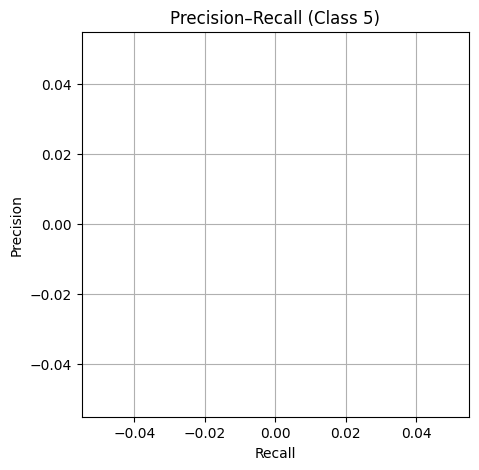

AP Class 5: 0.0000


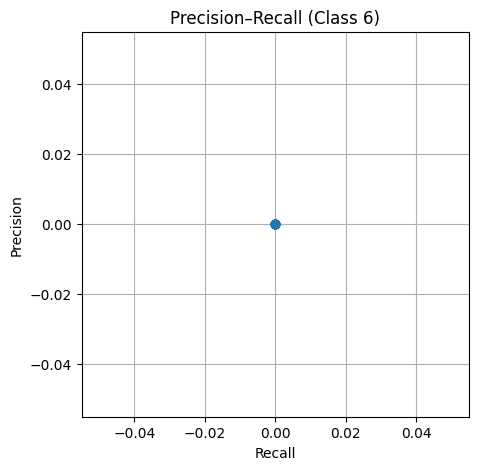

AP Class 6: 0.0000


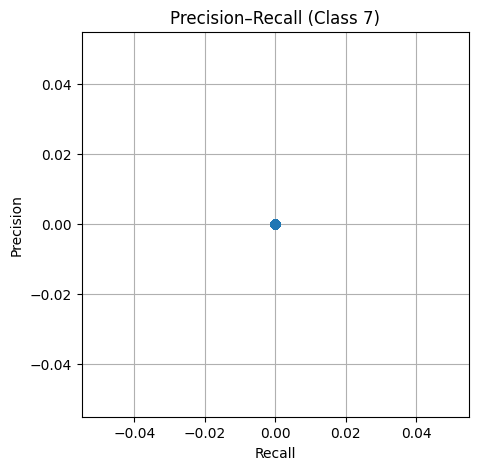

AP Class 7: 0.0000


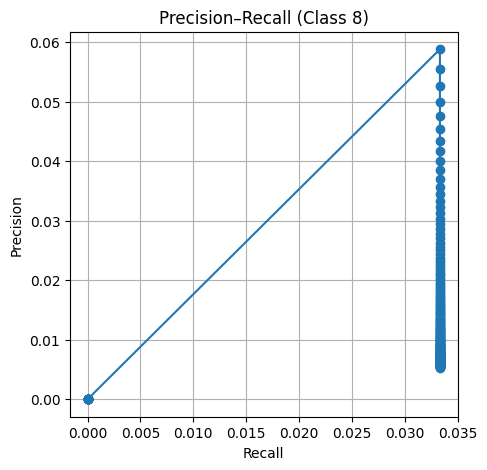

AP Class 8: 0.0010


ValueError: At least 2 points are needed to compute area under curve, but x.shape = 1

In [21]:
AP_per_class, mean_AP = compute_average_precision_multiclass(
    x_test, y_test, model_multi,
    generate_random_regions,
    preselectRegions,
    nonmaxSuppression,
    compareToGroundTruth,
    iou_threshold=0.5,
    n_regions=20
)



**Q9** (optionnel) Pour guider mieux le processus de génération de regions candidates, vous pouvez également orienter le processus aléatoire en considérant les régions de l'image où se trouvent beaucoup de points caractéristiques (Harris, SIFTs, etc.).
Est-ce que cela améliore les résultats ?
